In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tag import pos_tag
import tomotopy as tp
from tqdm import tqdm
from nltk import pos_tag
from nltk.tokenize import word_tokenize
# nltk.download()
nltk.download('stopwords')
nltk.download('punkt')
import spacy
import lemminflect
from lemminflect import getLemma
from operator import itemgetter
import sys
import os 
import re
import collections
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/youngeun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/youngeun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
stops = stopwords.words('english')
newstop = ['et', 'al', 'us','factor','evidence','review','analysis','impact','effect','example','research','paper','result',"first","second","third","forth",'doe', 'C', 'elsevier', 'ltd', 'etc', 'was', 'wa', 'ha', 'springer','mdpi','evaluation','evaluating']
stops.extend(newstop)
# path = '/Users/youngeun/Library/CloudStorage/OneDrive-충북대학교/05. 수업/08. AI 교육/ICT/digital_cc/0703'
# path = 'F:/02. 유영은(박사과정)/OneDrive - 충북대학교/05. 수업/08. AI 교육/ICT/digital_cc/0809/'
path = '/Users/youngeun/Library/CloudStorage/OneDrive-충북대학교/05. 수업/08. AI 교육/ICT/digital_cc/0809/'
os.chdir(path)

In [57]:
content = pd.read_excel('0818_cc_crawling.xlsx')
content2 = content.drop_duplicates(['Abstract'],keep='first',ignore_index=True)
content3 = content2.drop_duplicates(['Article Title'],keep='first',ignore_index=True)
print(content3.duplicated(['Abstract','Article Title']).sum())
content = content3
content

0


,Publication Year,Article Title,Source Title,WoS Categories,Abstract
0,2021,Climate change transformation: A definition an...,SUSTAINABLE CITIES AND SOCIETY,Construction & Building Technology; Green & Su...,Climate change presents a threat to the sustai...
1,2020,North American birds require mitigation and ad...,CONSERVATION SCIENCE AND PRACTICE,Biodiversity Conservation,"In an emerging climate crisis, effective conse..."
2,2011,Advent of Climate Change and Resultant Energy ...,SUSTAINABILITY IN ENERGY AND BUILDINGS,Construction & Building Technology; Energy & F...,By 2050s the UK is expected to experience: inc...
3,2019,The Problem of Lack of Green Space and Rise in...,SUSTAINABILITY IN ENERGY AND BUILDINGS 2018,Construction & Building Technology; Energy & F...,The urban heat island effect (UHI) is a produc...
4,2022,Resilient cooling pathway for extremely hot cl...,APPLIED ENERGY,"Energy & Fuels; Engineering, Chemical",Global warming is increasing extreme heat cond...
...,...,...,...,...,...
24965,2022,The influence of the synergistic effect of air...,FUEL,"Energy & Fuels; Engineering, Chemical",Coal is the important support to guarantee the...
24966,2022,Demand response flexibility with synergies on ...,RENEWABLE ENERGY,Green & Sustainable Science & Technology; Ener...,Energy-efficient buildings and renewable power...
24967,2003,Evaluating automobile fuel/propulsion system t...,PROGRESS IN ENERGY AND COMBUSTION SCIENCE,"Thermodynamics; Energy & Fuels; Engineering, C...",We examine the life cycle implications of a wi...
24968,2018,EDIBLE INSECTS - SAFE FOOD FOR HUMANS AND LIVE...,ECOLOGICAL AND ECONOMIC SIGNIFICANCE OF FAUNA ...,Biodiversity Conservation; Ecology; Entomology,This paper describes the contribution of insec...


In [147]:
class CustomTokenizer:
    def __call__(self, text):

        if text.istitle() == True:
            text = text.capitalize()
        elif text.isupper() == True:
            text = text.capitalize()
        elif text.islower() == True:
            text = text.capitalize()
        else:
            text
        
        pat = re.sub(r'[^A-Za-z0-9\\-]',' ', text)
        pat = re.sub(r' - ',' ',pat)
        pat = re.sub(r' -',' ',pat)
        pat = re.sub(r'- ',' ',pat)
        pat = pat.strip()
        pat = " ".join(pat.split())
        pat = re.sub(r'\b\sA\s\b',' ',pat); pat = re.sub(r'\b\sB\s\b',' ',pat); pat = re.sub(r'\b\sC\s\b',' ',pat); pat = re.sub(r'\b\sD\s\b',' ',pat); pat = re.sub(r'\b\sE\s\b',' ',pat); pat = re.sub(r'\b\sF\s\b',' ',pat); pat = re.sub(r'\b\sG\s\b',' ',pat); pat = re.sub(r'\b\sH\s\b',' ',pat); pat = re.sub(r'\b\sI\s\b',' ',pat); pat = re.sub(r'\b\sJ\s\b',' ',pat); pat = re.sub(r'\b\sK\s\b',' ',pat); pat = re.sub(r'\b\sL\s\b',' ',pat); pat = re.sub(r'\b\sM\s\b',' ',pat); pat = re.sub(r'\b\sN\s\b',' ',pat); pat = re.sub(r'\b\sO\s\b',' ',pat); pat = re.sub(r'\b\sP\s\b',' ',pat); pat = re.sub(r'\b\sQ\s\b',' ',pat); pat = re.sub(r'\b\sR\s\b',' ',pat); pat = re.sub(r'\b\sS\s\b',' ',pat); pat = re.sub(r'\b\sT\s\b',' ',pat); pat = re.sub(r'\b\sU\s\b',' ',pat); pat = re.sub(r'\b\sV\s\b',' ',pat); pat = re.sub(r'\b\sW\s\b',' ',pat); pat = re.sub(r'\b\sX\s\b',' ',pat); pat = re.sub(r'\b\sY\s\b',' ',pat); pat = re.sub(r'\b\sZ\s\b',' ',pat)
        pat = re.sub(r'\b\sa\s\b',' ',pat); pat = re.sub(r'\b\sb\s\b',' ',pat); pat = re.sub(r'\b\sc\s\b',' ',pat); pat = re.sub(r'\b\sd\s\b',' ',pat); pat = re.sub(r'\b\se\s\b',' ',pat); pat = re.sub(r'\b\sf\s\b',' ',pat); pat = re.sub(r'\b\sg\s\b',' ',pat); pat = re.sub(r'\b\sh\s\b',' ',pat); pat = re.sub(r'\b\si\s\b',' ',pat); pat = re.sub(r'\b\sj\s\b',' ',pat); pat = re.sub(r'\b\sk\s\b',' ',pat); pat = re.sub(r'\b\sl\s\b',' ',pat); pat = re.sub(r'\b\sm\s\b',' ',pat); pat = re.sub(r'\b\sn\s\b',' ',pat); pat = re.sub(r'\b\so\s\b',' ',pat); pat = re.sub(r'\b\sp\s\b',' ',pat); pat = re.sub(r'\b\sq\s\b',' ',pat); pat = re.sub(r'\b\sr\s\b',' ',pat); pat = re.sub(r'\b\ss\s\b',' ',pat); pat = re.sub(r'\b\st\s\b',' ',pat); pat = re.sub(r'\b\su\s\b',' ',pat); pat = re.sub(r'\b\sv\s\b',' ',pat); pat = re.sub(r'\b\sw\s\b',' ',pat); pat = re.sub(r'\b\sx\s\b',' ',pat); pat = re.sub(r'\b\sy\s\b',' ',pat); pat = re.sub(r'\b\sz\s\b',' ',pat)
        pat = re.sub(r'\b\s0\b\s',' ',pat); pat = re.sub(r'\b\s1\b\s',' ',pat); pat = re.sub(r'\b\s2\b\s',' ',pat); pat = re.sub(r'\b\s3\b\s',' ',pat); pat = re.sub(r'\b\s4\b\s',' ',pat); pat = re.sub(r'\b\s5\b\s',' ',pat); pat = re.sub(r'\b\s6\b\s',' ',pat); pat = re.sub(r'\b\s7\b\s',' ',pat); pat = re.sub(r'\b\s8\b\s',' ',pat); pat = re.sub(r'\b\s9\b\s',' ',pat)

        token = word_tokenize(pat)
        token = [w for w in token if not w in stops]
        token = [getLemma(w, upos='NOUN')[0] for w in token]
        tagged = pos_tag(token) # 첫번째 결과를 사용
        #print(tagged)
        pat2 = [w[0] for w in tagged if w[1] == 'NN' or  w[1] == 'NNP' or  w[1] == 'NNS' or  w[1] == 'NNPS' or  w[1] == 'JJ' or  w[1] == 'JJR' or  w[1] == 'JJS' or w[0].isupper() == True]
        pat2 = [getLemma(w, upos='NOUN')[0] for w in pat2]

        pat3 = []
        for w in pat2:
            if w[0:len(w)-1].isupper() == True:
                pat3.append(w)
            else:
                pat3.append(w.lower())
        pat4 = []
        for w in pat3:
            if not w in stops:
                pat4.append(w)
            
        # climate change 합치기
        pat5 = []
        for i in range(len(pat4)):
            if i == len(pat4)-1 and pat4[i] == 'climate':
                continue
            if pat4[i] == 'climate' and pat4[i+1] == 'change':
                pat5.append("-".join(itemgetter(i,i+1)(pat4)))
                continue
            pat5.append(pat4[i])
        pat6 = []
        for i in range(len(pat5)):
            if pat5[i-1] == 'climate-change' and pat5[i] == 'change':
                continue
            pat6.append(pat5[i])
        
        pat7 = []
        for i in range(len(pat6)):
            if i == len(pat6)-1 and pat6[i] == 'case':
                continue
            if pat6[i] == 'case' and pat6[i+1] == 'study':
                pat7.append("-".join(itemgetter(i,i+1)(pat6)))
                continue
            pat7.append(pat6[i])
        pat8 = []
        for i in range(len(pat7)):
            if pat7[i-1] == 'case-study' and pat7[i] == 'study':
                continue
            pat8.append(pat7[i])
            
        pat9 = []
        for i in range(len(pat8)):
            if i == len(pat8)-1 and pat8[i] == 'carbon':
                continue
            if pat8[i] == 'carbon' and pat8[i+1] == 'emission':
                pat9.append("-".join(itemgetter(i,i+1)(pat8)))
                continue
            pat9.append(pat8[i])
        pat10 = []
        for i in range(len(pat9)):
            if pat9[i-1] == 'carbon-emission' and pat9[i] == 'emission':
                continue
            pat10.append(pat9[i])
            
        pat11 = []
        for i in range(len(pat10)):
            if i == len(pat10)-1 and pat10[i] == 'carbon':
                continue
            if pat10[i] == 'carbon' and pat10[i+1] == 'reduction':
                pat11.append("-".join(itemgetter(i,i+1)(pat10)))
                continue
            pat11.append(pat10[i])
        pat12 = []
        for i in range(len(pat11)):
            if pat11[i-1] == 'carbon-reduction' and pat11[i] == 'reduction':
                continue
            pat12.append(pat11[i])

        pat13 = []
        for i in range(len(pat12)):
            if i == len(pat12)-1 and pat12[i] == 'carbon':
                continue
            if pat12[i] == 'carbon' and pat12[i+1] == 'neutral':
                pat13.append("-".join(itemgetter(i,i+1)(pat12)))
                continue
            pat13.append(pat12[i])
        pat14 = []
        for i in range(len(pat13)):
            if pat13[i-1] == 'carbon-neutral' and pat13[i] == 'neutral':
                continue
            pat14.append(pat13[i])

        pat15 = []
        for i in range(len(pat14)):
            if i == len(pat14)-1 and pat14[i] == 'carbon':
                continue
            if pat14[i] == 'carbon' and pat14[i+1] == 'neutrality':
                pat15.append("-".join(itemgetter(i,i+1)(pat14)))
                continue
            pat15.append(pat14[i])
        pat16 = []
        for i in range(len(pat15)):
            if pat15[i-1] == 'carbon-neutrality' and pat15[i] == 'neutrality':
                continue
            pat16.append(pat15[i])

        pat17 = []
        for i in range(len(pat16)):
            if i == len(pat16)-1 and pat16[i] == 'sustainable':
                continue
            if pat16[i] == 'sustainable' and pat16[i+1] == 'development':
                pat17.append("-".join(itemgetter(i,i+1)(pat16)))
                continue
            pat17.append(pat16[i])
        pat18 = []
        for i in range(len(pat17)):
            if pat17[i-1] == 'sustainable-development' and pat17[i] == 'development':
                continue
            pat18.append(pat17[i])

        pat19 = []
        for i in range(len(pat18)):
            if i == len(pat18)-1 and pat18[i] == 'heat':
                continue
            if pat18[i] == 'heat' and pat18[i+1] == 'island':
                pat19.append("-".join(itemgetter(i,i+1)(pat18)))
                continue
            pat19.append(pat18[i])
        pat20 = []
        for i in range(len(pat19)):
            if pat19[i-1] == 'heat-island' and pat19[i] == 'island':
                continue
            pat20.append(pat19[i])
            
        pat21 = []
        for i in range(len(pat20)):
            if i == len(pat20)-1 and pat20[i] == 'land':
                continue
            if pat20[i] == 'land' and pat20[i+1] == 'use':
                pat21.append("-".join(itemgetter(i,i+1)(pat20)))
                continue
            pat21.append(pat20[i])
        pat22 = []
        for i in range(len(pat21)):
            if pat21[i-1] == 'land-use' and pat21[i] == 'use':
                continue
            pat22.append(pat21[i])

        pat23 = []
        for i in range(len(pat22)):
            if i == len(pat22)-1 and pat22[i] == 'urban':
                continue
            if pat22[i] == 'urban' and pat22[i+1] == 'heat':
                pat23.append("-".join(itemgetter(i,i+1)(pat22)))
                continue
            pat23.append(pat22[i])
        pat24 = []
        for i in range(len(pat23)):
            if pat23[i-1] == 'urban-heat' and pat23[i] == 'heat':
                continue
            pat24.append(pat23[i])

        pat25 = []
        for i in range(len(pat24)):
            if i == len(pat24)-1 and pat24[i] == 'green':
                continue
            if pat24[i] == 'green' and pat24[i+1] == 'space':
                pat25.append("-".join(itemgetter(i,i+1)(pat24)))
                continue
            pat25.append(pat24[i])
        pat26 = []
        for i in range(len(pat25)):
            if pat25[i-1] == 'green-space' and pat25[i] == 'space':
                continue
            pat26.append(pat25[i])

        pat27 = []
        for i in range(len(pat26)):
            if i == len(pat26)-1 and pat26[i] == 'green':
                continue
            if pat26[i] == 'green' and pat26[i+1] == 'area':
                pat27.append("-".join(itemgetter(i,i+1)(pat26)))
                continue
            pat27.append(pat26[i])
        pat28 = []
        for i in range(len(pat27)):
            if pat27[i-1] == 'green-area' and pat27[i] == 'area':
                continue
            pat28.append(pat27[i])


        for i in range(len(pat28)):
            if pat28[i] == 'CC':
                pat28[i] = 'climate-change'

        for i in range(len(pat28)):
            if pat28[i] == 'GHG':
                pat28[i] = 'greenhous-gas'

        for i in range(len(pat28)):
            if pat28[i] == 'CO':
                pat28[i] = 'CO2'

        pat28 = [w for w in pat28 if not len(w) == 1]

        return ' '.join(pat28)

In [11]:
custom_tokenizer = CustomTokenizer()
sentence = []
for i in tqdm(content['Article Title']):
    sentence.append(custom_tokenizer(i))

word = []
for line in tqdm(sentence):
    tokens = word_tokenize(line)
    word.append(tokens)

100%|██████████| 24970/24970 [00:02<00:00, 11538.21it/s]


In [12]:
print(len(sentence))
print(len(content))
print(len(word))

print(content['Article Title'][2000])
print(sentence[2000])
print(word[2000])

24970
24970
24970
Discussion on key technologies of big data in financial budget performance management in low-carbon economy
discussion key technology big data financial budget performance management low-carbon economy
['discussion', 'key', 'technology', 'big', 'data', 'financial', 'budget', 'performance', 'management', 'low-carbon', 'economy']


In [17]:
for i in tqdm(range(0,20)):
    words = sum(word, [])

words

100%|██████████| 20/20 [05:05<00:00, 15.30s/it]


['climate-change',
 'transformation',
 'definition',
 'typology',
 'guide',
 'decision',
 'urban',
 'environment',
 'north',
 'american',
 'bird',
 'require',
 'mitigation',
 'adaptation',
 'vulnerability',
 'climate-change',
 'advent',
 'climate-change',
 'resultant',
 'energy',
 'relate',
 'obsolescence',
 'environment',
 'problem',
 'lack',
 'green',
 'space',
 'rise',
 'surface',
 'temperature',
 'city',
 'resilient',
 'hot',
 'climate',
 'southern',
 'asia',
 'life-cycle',
 'carbon',
 'footprint',
 'redesign',
 'water',
 'distribution',
 'system',
 'low',
 'carbon',
 'electricity',
 'system',
 'indium',
 'multi-objective',
 'multi-criterion',
 'assessment',
 'climate-change',
 'socio-hydrological',
 'space',
 'brahmaputra',
 'assam',
 'northeast',
 'indium',
 'ecohydrology',
 'coastal',
 'aquifer',
 'humid',
 'environment',
 'implication',
 'climate-change',
 'mitigation',
 'adaptation',
 'long-term',
 'power',
 'system',
 'expansion',
 'conservation',
 'effort',
 'face',
 'change

In [18]:
counts = collections.Counter(words)
tags = counts.most_common()
tags[1:40]

[('system', 3036),
 ('climate-change', 2560),
 ('carbon', 2503),
 ('water', 1785),
 ('assessment', 1656),
 ('china', 1467),
 ('power', 1460),
 ('building', 1318),
 ('emission', 1280),
 ('model', 1193),
 ('low-carbon', 1148),
 ('production', 1132),
 ('co2', 1100),
 ('development', 1085),
 ('management', 1027),
 ('urban', 1023),
 ('renewable', 1017),
 ('performance', 1017),
 ('storage', 1010),
 ('climate', 991),
 ('gas', 966),
 ('technology', 948),
 ('potential', 920),
 ('policy', 919),
 ('future', 903),
 ('low', 880),
 ('strategy', 861),
 ('case-study', 853),
 ('approach', 849),
 ('study', 839),
 ('fuel', 827),
 ('adaptation', 813),
 ('environmental', 811),
 ('design', 798),
 ('sustainable', 797),
 ('hydrogen', 772),
 ('solar', 762),
 ('heat', 726),
 ('application', 696)]

In [19]:
tag_df=pd.DataFrame(tags, columns=["word","freq"])
pd.DataFrame(tag_df).to_csv('0818_most_word_cc_title.csv', index=False)

In [5]:
import gensim
import gensim.downloader as api
model = api.load("glove-wiki-gigaword-300")
model = gensim.models.KeyedVectors.load_word2vec_format('~/gensim-data/glove-wiki-gigaword-300/glove-wiki-gigaword-300.gz')
print(model)

KeyedVectors<vector_size=300, 400000 keys>


In [77]:
mostword = pd.read_excel('cc_classification.xlsx')
mostword

,category,toxic
0,energy,11
1,industry,12
2,waste,13
3,traffic,14
4,building,15
5,land-use,16
6,green,21
7,biodiversity,22
8,water,23
9,heat island,24


(AND) Title : energy OR electricity OR industry OR waste OR traffic OR transport OR vehicle OR built OR building OR Infra*  OR "land use" OR "green space" OR "green area" OR biodiversity OR water OR flood OR drought OR "heat wave" OR "heat island" OR "urban heat" OR city OR urban OR "urban space" OR "urban place"

완화 : 에너지, 산업, 폐기물, 교통, 건축물, 토지이용
적응 : 녹지, 생물다양성, 물, 열섬

In [6]:
sort = pd.DataFrame({'cate':["energy","energy","industry","waste","traffic","traffic","traffic","building","building","biodiversity","water","water","water"],
                     'similar_word':["energy","electricity","industry","waste","traffic","transport","vehicle","built","building","biodiversity","water","flood","drought"],
                     'toxic':[11,11,12,13,14,14,14,15,15,22,23,23,23]})
sort

,cate,similar_word,toxic
0,energy,energy,11
1,energy,electricity,11
2,industry,industry,12
3,waste,waste,13
4,traffic,traffic,14
5,traffic,transport,14
6,traffic,vehicle,14
7,building,built,15
8,building,building,15
9,biodiversity,biodiversity,22


In [46]:
most_similar = []
weight = []
for j in tqdm(range(0,500)):
    if model.most_similar(sort['similar_word'][1], topn=500)[j][1] >= 0.5:
        if model.most_similar(sort['similar_word'][1], topn=500)[j][0] not in sort['cate'].unique():
            if model.most_similar(sort['similar_word'][1], topn=500)[j][0] not in sort['similar_word'].unique():
                most_similar.append(getLemma(model.most_similar(sort['similar_word'][1], topn=500)[j][0], upos='NOUN')[0])
                weight.append(model.most_similar(sort['similar_word'][1], topn=500)[j][1])

100%|██████████| 500/500 [00:04<00:00, 106.19it/s]


In [47]:
most_similar

['utility',
 'megawatt',
 'generator',
 'power',
 'electrical',
 'generating',
 'supply',
 'gas',
 'electric',
 'utility',
 'fuel',
 'generator',
 'hydroelectric',
 'heating',
 'supply',
 'renewable',
 'grid']

In [48]:
word = pd.DataFrame({'cate':["energy","energy","industry","waste","traffic","traffic","traffic","building","building","land-use","green",
                             "green","biodiversity","water","water","water","heat island","heat island"],
                     'toxic':[11,11,12,13,14,14,14,15,15,16,21,21,22,23,23,23,24,24],
                     'similar_word':["energy","electricity","industry","waste","traffic","transport","vehicle","built","building","land-use","green-space",
                                    "green-area","biodiversity","water","flood","drought","heat-island","urban-heat"],
                     'weight':[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]})

    
similar_result = {'cate': [], 'toxic': [], 'similar_word': [], 'weight' : []}
for i in tqdm(range(len(sort))):
    for j in tqdm(range(0,500)):
        if model.most_similar(sort['similar_word'][i], topn=500)[j][1] >= 0.5:
            if model.most_similar(sort['similar_word'][i], topn=500)[j][0] not in sort['cate'].unique():
                if model.most_similar(sort['similar_word'][i], topn=500)[j][0] not in sort['similar_word'].unique():
                    similar_result['cate'].append(sort['cate'][i])
                    similar_result['toxic'].append(sort['toxic'][i])
                    similar_result['similar_word'].append(getLemma(model.most_similar(sort['similar_word'][i], topn=500)[j][0], upos='NOUN')[0])
                    similar_result['weight'].append(model.most_similar(sort['similar_word'][i], topn=500)[j][1])

100%|██████████| 13/13 [01:07<00:00,  5.21s/it]


In [85]:
similar_results = pd.DataFrame(similar_result)
result = pd.concat([word,similar_results])
result = result.sort_values(['toxic'])
# result = result.sort_values('weight', ascending=False).drop_duplicates(subset=['cate', 'similar_word'], ignore_index=True)
result = result.drop_duplicates(['cate','similar_word'],keep='first',ignore_index=True)
# pd.DataFrame(result).to_excel('0818_similar_result.xlsx', index=False)

result

,cate,toxic,similar_word,weight
0,energy,11,energy,1.000000
1,energy,11,megawatt,0.599244
2,energy,11,generator,0.594029
3,energy,11,power,0.591090
4,energy,11,electrical,0.589560
...,...,...,...,...
162,water,23,rainfall,0.514291
163,water,23,clean,0.504775
164,water,23,severe,0.508795
165,heat island,24,heat-island,1.000000


In [86]:
result = pd.read_excel('0818_similar_result.xlsx')
result

,cate,toxic,similar_word,weight
0,energy,11,energy,1.000000
1,energy,11,megawatt,0.599244
2,energy,11,generator,0.594029
3,energy,11,power,0.591090
4,energy,11,electrical,0.589560
...,...,...,...,...
124,water,23,irrigation,0.554944
125,water,23,drinking,0.592538
126,water,23,rainfall,0.514291
127,heat island,24,heat-island,1.000000


In [87]:
pd.set_option('mode.chained_assignment',  None)

content['words'] = 0
content['energy'] = 0
content['industry'] = 0
content['waste'] = 0
content['traffic'] = 0
content['building'] = 0
content['land-use'] = 0
content['green'] = 0
content['biodiversity'] = 0
content['water'] = 0
content['heat island'] = 0
content

,Publication Year,Article Title,Source Title,WoS Categories,Abstract,words,energy,industry,waste,traffic,building,land-use,green,biodiversity,water,heat island
0,2021,Climate change transformation: A definition an...,SUSTAINABLE CITIES AND SOCIETY,Construction & Building Technology; Green & Su...,Climate change presents a threat to the sustai...,0,0,0,0,0,0,0,0,0,0,0
1,2020,North American birds require mitigation and ad...,CONSERVATION SCIENCE AND PRACTICE,Biodiversity Conservation,"In an emerging climate crisis, effective conse...",0,0,0,0,0,0,0,0,0,0,0
2,2011,Advent of Climate Change and Resultant Energy ...,SUSTAINABILITY IN ENERGY AND BUILDINGS,Construction & Building Technology; Energy & F...,By 2050s the UK is expected to experience: inc...,0,0,0,0,0,0,0,0,0,0,0
3,2019,The Problem of Lack of Green Space and Rise in...,SUSTAINABILITY IN ENERGY AND BUILDINGS 2018,Construction & Building Technology; Energy & F...,The urban heat island effect (UHI) is a produc...,0,0,0,0,0,0,0,0,0,0,0
4,2022,Resilient cooling pathway for extremely hot cl...,APPLIED ENERGY,"Energy & Fuels; Engineering, Chemical",Global warming is increasing extreme heat cond...,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24965,2022,The influence of the synergistic effect of air...,FUEL,"Energy & Fuels; Engineering, Chemical",Coal is the important support to guarantee the...,0,0,0,0,0,0,0,0,0,0,0
24966,2022,Demand response flexibility with synergies on ...,RENEWABLE ENERGY,Green & Sustainable Science & Technology; Ener...,Energy-efficient buildings and renewable power...,0,0,0,0,0,0,0,0,0,0,0
24967,2003,Evaluating automobile fuel/propulsion system t...,PROGRESS IN ENERGY AND COMBUSTION SCIENCE,"Thermodynamics; Energy & Fuels; Engineering, C...",We examine the life cycle implications of a wi...,0,0,0,0,0,0,0,0,0,0,0
24968,2018,EDIBLE INSECTS - SAFE FOOD FOR HUMANS AND LIVE...,ECOLOGICAL AND ECONOMIC SIGNIFICANCE OF FAUNA ...,Biodiversity Conservation; Ecology; Entomology,This paper describes the contribution of insec...,0,0,0,0,0,0,0,0,0,0,0


In [88]:
custom_tokenizer = CustomTokenizer()
for i in tqdm(range(len(content))):
    sentence = custom_tokenizer(content['Article Title'][i])
    tokens = word_tokenize(sentence)
    content['words'][i] = ' '.join(tokens)
content

100%|██████████| 24970/24970 [00:35<00:00, 695.39it/s]


,Publication Year,Article Title,Source Title,WoS Categories,Abstract,words,energy,industry,waste,traffic,building,land-use,green,biodiversity,water,heat island
0,2021,Climate change transformation: A definition an...,SUSTAINABLE CITIES AND SOCIETY,Construction & Building Technology; Green & Su...,Climate change presents a threat to the sustai...,climate-change transformation definition typol...,0,0,0,0,0,0,0,0,0,0
1,2020,North American birds require mitigation and ad...,CONSERVATION SCIENCE AND PRACTICE,Biodiversity Conservation,"In an emerging climate crisis, effective conse...",north american bird require mitigation adaptat...,0,0,0,0,0,0,0,0,0,0
2,2011,Advent of Climate Change and Resultant Energy ...,SUSTAINABILITY IN ENERGY AND BUILDINGS,Construction & Building Technology; Energy & F...,By 2050s the UK is expected to experience: inc...,advent climate-change resultant energy relate ...,0,0,0,0,0,0,0,0,0,0
3,2019,The Problem of Lack of Green Space and Rise in...,SUSTAINABILITY IN ENERGY AND BUILDINGS 2018,Construction & Building Technology; Energy & F...,The urban heat island effect (UHI) is a produc...,problem lack green-space rise surface temperat...,0,0,0,0,0,0,0,0,0,0
4,2022,Resilient cooling pathway for extremely hot cl...,APPLIED ENERGY,"Energy & Fuels; Engineering, Chemical",Global warming is increasing extreme heat cond...,resilient hot climate southern asia,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24965,2022,The influence of the synergistic effect of air...,FUEL,"Energy & Fuels; Engineering, Chemical",Coal is the important support to guarantee the...,influence synergistic airflow vibration compou...,0,0,0,0,0,0,0,0,0,0
24966,2022,Demand response flexibility with synergies on ...,RENEWABLE ENERGY,Green & Sustainable Science & Technology; Ener...,Energy-efficient buildings and renewable power...,demand response flexibility passive pcm wall a...,0,0,0,0,0,0,0,0,0,0
24967,2003,Evaluating automobile fuel/propulsion system t...,PROGRESS IN ENERGY AND COMBUSTION SCIENCE,"Thermodynamics; Energy & Fuels; Engineering, C...",We examine the life cycle implications of a wi...,automobile fuel propulsion system technology,0,0,0,0,0,0,0,0,0,0
24968,2018,EDIBLE INSECTS - SAFE FOOD FOR HUMANS AND LIVE...,ECOLOGICAL AND ECONOMIC SIGNIFICANCE OF FAUNA ...,Biodiversity Conservation; Ecology; Entomology,This paper describes the contribution of insec...,edible insect safe food human livestock,0,0,0,0,0,0,0,0,0,0


In [89]:
print(content['Article Title'][0])
print(content['words'][0])
print(content['Article Title'][2000])
print(content['words'][2000])

Climate change transformation: A definition and typology to guide decision making in urban environments
climate-change transformation definition typology guide decision urban environment
Discussion on key technologies of big data in financial budget performance management in low-carbon economy
discussion key technology big data financial budget performance management low-carbon economy


In [90]:
category = result['cate'].unique()

In [91]:
if result['similar_word'][result['cate'] == result['cate'].unique()[0]][0] in content['words'][2]:
    print(result['similar_word'][result['cate'] == result['cate'].unique()[0]][0])
else:
    print(content['words'][1])
    print(result['similar_word'][result['cate'] == result['cate'].unique()[0]][0])

energy


In [92]:
count = [[] for _ in range(len(category))]
for j in range(len(category)):
    count[j] = [[] for _ in range(len(content))]
    for i in tqdm(range(len(content))):
        count[j][i] = 0       
        for k in range(len(result['similar_word'][result['cate'] == category[j]])):
            if list(result['similar_word'][result['cate'] == category[j]])[k] in content['words'][i]:
                count[j][i]= +list(result['weight'][result['cate'] == category[j]])[k]
            content.iloc[:,6+j][i] = count[j][i]

100%|██████████| 24970/24970 [00:10<00:00, 2348.91it/s]


In [93]:
list(content['Article Title'][content['energy'] != 0])[0:10]

['Advent of Climate Change and Resultant Energy Related Obsolescence in the Built Environment',
 'Low carbon electricity system for India in 2030 based on multi-objective multi-criteria assessment',
 'Seeking for a climate change mitigation and adaptation nexus: Analysis of a long-term power system expansion',
 'Projected changes in wind speed and its energy potential in China using a high-resolution regional climate model',
 'A comprehensive outlook on topical processing methods for biofuel production and its thermal applications: Current advances, sustainability and challenges',
 'Climate resilience analysis by social evolutions in the COVID-19 pandemic incorporated with energy mix strategy',
 'Nanomaterials as highly efficient photocatalysts used for bioenergy and biohydrogen production from waste toward a sustainable environment',
 'Power electronics contribution to renewable energy conversion addressing emission reduction: Applications, issues, and recommendations',
 'The Use of N

In [120]:
contents = content.copy()
contents.insert(6, 'sum', content[content.columns.difference(['Publication Year'])].sum(axis = 1, numeric_only = True))
contents = contents[contents['sum'] != 0]
contents

,Publication Year,Article Title,Source Title,WoS Categories,Abstract,words,sum,energy,industry,waste,traffic,building,land-use,green,biodiversity,water,heat island
2,2011,Advent of Climate Change and Resultant Energy ...,SUSTAINABILITY IN ENERGY AND BUILDINGS,Construction & Building Technology; Energy & F...,By 2050s the UK is expected to experience: inc...,advent climate-change resultant energy relate ...,1.000000,1.000000,0.0,0.0,0.000000,0.000000,0,0.0,0.0,0.000000,0
3,2019,The Problem of Lack of Green Space and Rise in...,SUSTAINABILITY IN ENERGY AND BUILDINGS 2018,Construction & Building Technology; Energy & F...,The urban heat island effect (UHI) is a produc...,problem lack green-space rise surface temperat...,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0,1.0,0.0,0.000000,0
5,2013,Reducing life-cycle carbon footprints in the r...,JOURNAL OF WATER AND CLIMATE CHANGE,Water Resources,Water distribution systems (WDSs) contribute t...,life-cycle carbon footprint redesign water dis...,1.301726,0.000000,0.0,0.0,0.765537,0.000000,0,0.0,0.0,0.536189,0
6,2021,Low carbon electricity system for India in 203...,RENEWABLE & SUSTAINABLE ENERGY REVIEWS,Green & Sustainable Science & Technology; Ener...,Renewable energy is considered crucial for cli...,low carbon electricity system indium multi-obj...,1.765537,1.000000,0.0,0.0,0.765537,0.000000,0,0.0,0.0,0.000000,0
9,2020,Seeking for a climate change mitigation and ad...,APPLIED ENERGY,"Energy & Fuels; Engineering, Chemical",Reductions in carbon emissions have been a foc...,climate-change mitigation adaptation long-term...,0.591090,0.591090,0.0,0.0,0.000000,0.000000,0,0.0,0.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24961,2022,Multi-criteria optimisation of integrated powe...,ENERGY SOURCES PART A-RECOVERY UTILIZATION AND...,"Energy & Fuels; Engineering, Chemical; Environ...",This paper presents a multi-criteria optimizat...,multi-criterion optimisation power system low-...,0.591090,0.591090,0.0,0.0,0.000000,0.000000,0,0.0,0.0,0.000000,0
24962,2022,Optimization of the solar space heating system...,RENEWABLE ENERGY,Green & Sustainable Science & Technology; Ener...,The employment of solar space heating is a sig...,optimization solar space heating system therma...,1.000000,1.000000,0.0,0.0,0.000000,0.000000,0,0.0,0.0,0.000000,0
24965,2022,The influence of the synergistic effect of air...,FUEL,"Energy & Fuels; Engineering, Chemical",Coal is the important support to guarantee the...,influence synergistic airflow vibration compou...,0.541830,0.000000,0.0,0.0,0.000000,0.000000,0,0.0,0.0,0.541830,0
24966,2022,Demand response flexibility with synergies on ...,RENEWABLE ENERGY,Green & Sustainable Science & Technology; Ener...,Energy-efficient buildings and renewable power...,demand response flexibility passive pcm wall a...,0.526013,0.000000,0.0,0.0,0.000000,0.526013,0,0.0,0.0,0.000000,0


In [111]:
content[content.columns.difference(['Publication Year'])].idxmax(axis = 1, numeric_only = True)[2]

'energy'

In [121]:
contents.insert(6,'final_cate',contents[contents.columns.difference(['Publication Year','sum'])].idxmax(axis = 1, numeric_only = True))
contents

,Publication Year,Article Title,Source Title,WoS Categories,Abstract,words,final_cate,sum,energy,industry,waste,traffic,building,land-use,green,biodiversity,water,heat island
2,2011,Advent of Climate Change and Resultant Energy ...,SUSTAINABILITY IN ENERGY AND BUILDINGS,Construction & Building Technology; Energy & F...,By 2050s the UK is expected to experience: inc...,advent climate-change resultant energy relate ...,energy,1.000000,1.000000,0.0,0.0,0.000000,0.000000,0,0.0,0.0,0.000000,0
3,2019,The Problem of Lack of Green Space and Rise in...,SUSTAINABILITY IN ENERGY AND BUILDINGS 2018,Construction & Building Technology; Energy & F...,The urban heat island effect (UHI) is a produc...,problem lack green-space rise surface temperat...,green,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0,1.0,0.0,0.000000,0
5,2013,Reducing life-cycle carbon footprints in the r...,JOURNAL OF WATER AND CLIMATE CHANGE,Water Resources,Water distribution systems (WDSs) contribute t...,life-cycle carbon footprint redesign water dis...,traffic,1.301726,0.000000,0.0,0.0,0.765537,0.000000,0,0.0,0.0,0.536189,0
6,2021,Low carbon electricity system for India in 203...,RENEWABLE & SUSTAINABLE ENERGY REVIEWS,Green & Sustainable Science & Technology; Ener...,Renewable energy is considered crucial for cli...,low carbon electricity system indium multi-obj...,energy,1.765537,1.000000,0.0,0.0,0.765537,0.000000,0,0.0,0.0,0.000000,0
9,2020,Seeking for a climate change mitigation and ad...,APPLIED ENERGY,"Energy & Fuels; Engineering, Chemical",Reductions in carbon emissions have been a foc...,climate-change mitigation adaptation long-term...,energy,0.591090,0.591090,0.0,0.0,0.000000,0.000000,0,0.0,0.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24961,2022,Multi-criteria optimisation of integrated powe...,ENERGY SOURCES PART A-RECOVERY UTILIZATION AND...,"Energy & Fuels; Engineering, Chemical; Environ...",This paper presents a multi-criteria optimizat...,multi-criterion optimisation power system low-...,energy,0.591090,0.591090,0.0,0.0,0.000000,0.000000,0,0.0,0.0,0.000000,0
24962,2022,Optimization of the solar space heating system...,RENEWABLE ENERGY,Green & Sustainable Science & Technology; Ener...,The employment of solar space heating is a sig...,optimization solar space heating system therma...,energy,1.000000,1.000000,0.0,0.0,0.000000,0.000000,0,0.0,0.0,0.000000,0
24965,2022,The influence of the synergistic effect of air...,FUEL,"Energy & Fuels; Engineering, Chemical",Coal is the important support to guarantee the...,influence synergistic airflow vibration compou...,water,0.541830,0.000000,0.0,0.0,0.000000,0.000000,0,0.0,0.0,0.541830,0
24966,2022,Demand response flexibility with synergies on ...,RENEWABLE ENERGY,Green & Sustainable Science & Technology; Ener...,Energy-efficient buildings and renewable power...,demand response flexibility passive pcm wall a...,building,0.526013,0.000000,0.0,0.0,0.000000,0.526013,0,0.0,0.0,0.000000,0


In [134]:
pd.DataFrame(contents).to_excel('0818_final_cc_contents.xlsx', index=False)
contents['final_cate'].unique()

array(['energy', 'green', 'traffic', 'biodiversity', 'building', 'water',
       'heat island', 'waste', 'industry', 'land-use'], dtype=object)

In [133]:
list(contents['Article Title'][contents['final_cate']=='heat island'])

['Educational building retrofit under climate change and urban heat island effect',
 'Performance assessment of seawater cooled chillers to mitigate urban heat island',
 'A simple tree planting framework to improve climate, air pollution, health, and urban heat in vulnerable locations using non-traditional partners',
 'Innovative pavement surfaces as urban heat islands mitigation strategy: chromatic, thermal and mechanical characterisation of clear/coloured mixtures',
 "Environmental impacts of reflective materials: Is high albedo a 'silver bullet' for mitigating urban heat island?",
 "Adaptation measures for climate change and the urban heat island in Japan's built environment",
 'Balancing conflicting mitigation and adaptation behaviours of urban residents under climate change and the urban heat island effect',
 'Contextual heat island assessment for pavement preservation',
 'Urban Heat Island (UHI) mitigating strategies: A case-based comparative analysis',
 'Assessing the impacts of

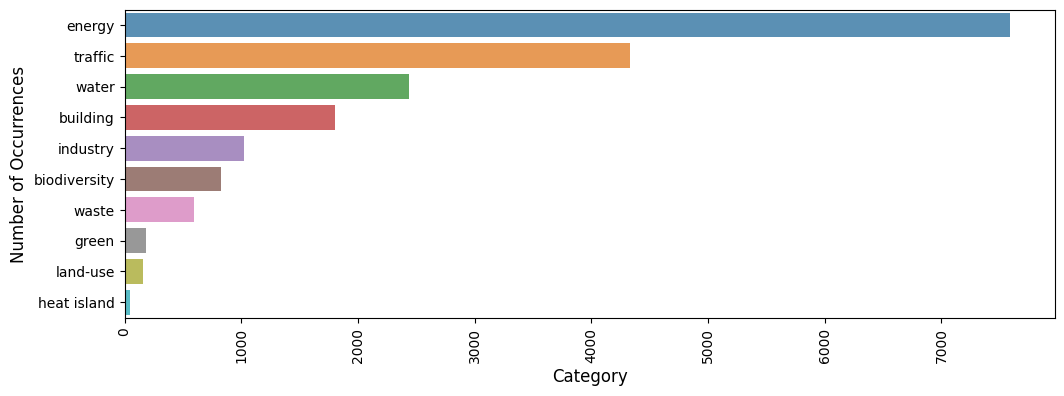

In [123]:
cnt = contents['final_cate'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x = cnt.values, y = cnt.index, alpha = 0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [135]:
train_dataset = contents.loc[:, :'final_cate']
train_dataset

,Publication Year,Article Title,Source Title,WoS Categories,Abstract,words,final_cate
2,2011,Advent of Climate Change and Resultant Energy ...,SUSTAINABILITY IN ENERGY AND BUILDINGS,Construction & Building Technology; Energy & F...,By 2050s the UK is expected to experience: inc...,advent climate-change resultant energy relate ...,energy
3,2019,The Problem of Lack of Green Space and Rise in...,SUSTAINABILITY IN ENERGY AND BUILDINGS 2018,Construction & Building Technology; Energy & F...,The urban heat island effect (UHI) is a produc...,problem lack green-space rise surface temperat...,green
5,2013,Reducing life-cycle carbon footprints in the r...,JOURNAL OF WATER AND CLIMATE CHANGE,Water Resources,Water distribution systems (WDSs) contribute t...,life-cycle carbon footprint redesign water dis...,traffic
6,2021,Low carbon electricity system for India in 203...,RENEWABLE & SUSTAINABLE ENERGY REVIEWS,Green & Sustainable Science & Technology; Ener...,Renewable energy is considered crucial for cli...,low carbon electricity system indium multi-obj...,energy
9,2020,Seeking for a climate change mitigation and ad...,APPLIED ENERGY,"Energy & Fuels; Engineering, Chemical",Reductions in carbon emissions have been a foc...,climate-change mitigation adaptation long-term...,energy
...,...,...,...,...,...,...,...
24961,2022,Multi-criteria optimisation of integrated powe...,ENERGY SOURCES PART A-RECOVERY UTILIZATION AND...,"Energy & Fuels; Engineering, Chemical; Environ...",This paper presents a multi-criteria optimizat...,multi-criterion optimisation power system low-...,energy
24962,2022,Optimization of the solar space heating system...,RENEWABLE ENERGY,Green & Sustainable Science & Technology; Ener...,The employment of solar space heating is a sig...,optimization solar space heating system therma...,energy
24965,2022,The influence of the synergistic effect of air...,FUEL,"Energy & Fuels; Engineering, Chemical",Coal is the important support to guarantee the...,influence synergistic airflow vibration compou...,water
24966,2022,Demand response flexibility with synergies on ...,RENEWABLE ENERGY,Green & Sustainable Science & Technology; Ener...,Energy-efficient buildings and renewable power...,demand response flexibility passive pcm wall a...,building


In [142]:
sorts = word[['cate','toxic']].drop_duplicates(['cate','toxic'],keep='first',ignore_index=True)
sorts

,cate,toxic
0,energy,11
1,industry,12
2,waste,13
3,traffic,14
4,building,15
5,land-use,16
6,green,21
7,biodiversity,22
8,water,23
9,heat island,24


In [143]:
train_dataset = pd.merge(train_dataset,sorts, how='left', left_on='final_cate', right_on='cate')
train_dataset

,Publication Year,Article Title,Source Title,WoS Categories,Abstract,words,final_cate,cate,toxic
0,2011,Advent of Climate Change and Resultant Energy ...,SUSTAINABILITY IN ENERGY AND BUILDINGS,Construction & Building Technology; Energy & F...,By 2050s the UK is expected to experience: inc...,advent climate-change resultant energy relate ...,energy,energy,11
1,2019,The Problem of Lack of Green Space and Rise in...,SUSTAINABILITY IN ENERGY AND BUILDINGS 2018,Construction & Building Technology; Energy & F...,The urban heat island effect (UHI) is a produc...,problem lack green-space rise surface temperat...,green,green,21
2,2013,Reducing life-cycle carbon footprints in the r...,JOURNAL OF WATER AND CLIMATE CHANGE,Water Resources,Water distribution systems (WDSs) contribute t...,life-cycle carbon footprint redesign water dis...,traffic,traffic,14
3,2021,Low carbon electricity system for India in 203...,RENEWABLE & SUSTAINABLE ENERGY REVIEWS,Green & Sustainable Science & Technology; Ener...,Renewable energy is considered crucial for cli...,low carbon electricity system indium multi-obj...,energy,energy,11
4,2020,Seeking for a climate change mitigation and ad...,APPLIED ENERGY,"Energy & Fuels; Engineering, Chemical",Reductions in carbon emissions have been a foc...,climate-change mitigation adaptation long-term...,energy,energy,11
...,...,...,...,...,...,...,...,...,...
18984,2022,Multi-criteria optimisation of integrated powe...,ENERGY SOURCES PART A-RECOVERY UTILIZATION AND...,"Energy & Fuels; Engineering, Chemical; Environ...",This paper presents a multi-criteria optimizat...,multi-criterion optimisation power system low-...,energy,energy,11
18985,2022,Optimization of the solar space heating system...,RENEWABLE ENERGY,Green & Sustainable Science & Technology; Ener...,The employment of solar space heating is a sig...,optimization solar space heating system therma...,energy,energy,11
18986,2022,The influence of the synergistic effect of air...,FUEL,"Energy & Fuels; Engineering, Chemical",Coal is the important support to guarantee the...,influence synergistic airflow vibration compou...,water,water,23
18987,2022,Demand response flexibility with synergies on ...,RENEWABLE ENERGY,Green & Sustainable Science & Technology; Ener...,Energy-efficient buildings and renewable power...,demand response flexibility passive pcm wall a...,building,building,15


In [144]:
train_dataset = train_dataset[['Abstract','cate','toxic']]
train_dataset

,Abstract,toxic
0,By 2050s the UK is expected to experience: inc...,11
1,The urban heat island effect (UHI) is a produc...,21
2,Water distribution systems (WDSs) contribute t...,14
3,Renewable energy is considered crucial for cli...,11
4,Reductions in carbon emissions have been a foc...,11
...,...,...
18984,This paper presents a multi-criteria optimizat...,11
18985,The employment of solar space heating is a sig...,11
18986,Coal is the important support to guarantee the...,23
18987,Energy-efficient buildings and renewable power...,15


In [145]:
print(sorted(train_dataset['toxic'].unique()))
print(len(train_dataset['toxic'].unique()))

[11, 12, 13, 14, 15, 16, 21, 22, 23, 24]
10


In [148]:
dataset_cp = train_dataset.copy()
dataset_cp['token'] = 0

for i in tqdm(dataset_cp['Abstract']):
    dataset_cp['token'].loc[dataset_cp['Abstract']==i] = custom_tokenizer(i)

dataset_cp

100%|██████████| 18989/18989 [05:33<00:00, 56.86it/s]


,Abstract,toxic,token
0,By 2050s the UK is expected to experience: inc...,11,uk experience increase average summer mean tem...
1,The urban heat island effect (UHI) is a produc...,21,urban heat-island uhu product urbanization cer...
2,Water distribution systems (WDSs) contribute t...,14,water distribution system contribute undesirab...
3,Renewable energy is considered crucial for cli...,11,renewable energy crucial climate-change mitiga...
4,Reductions in carbon emissions have been a foc...,11,reduction carbon-emission focus power sector s...
...,...,...,...
18984,This paper presents a multi-criteria optimizat...,11,present multi-criterion optimization power sys...
18985,The employment of solar space heating is a sig...,11,employment solar space heating significant mea...
18986,Coal is the important support to guarantee the...,23,coal important support guarantee national ener...
18987,Energy-efficient buildings and renewable power...,15,energy-efficient building renewable power supp...


In [151]:
pd.DataFrame(dataset_cp).to_excel('0818_cc_train_token.xlsx',header=['Abstract','toxic','token','category'])

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers.rnn import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout, Embedding
from keras.layers.normalization import batch_normalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import os 

In [15]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


[data split]

train, validataion, test 로 쪼개기

In [44]:
train_dataset

,Abstract,toxic
2,"Fossil fuel consumption, luxurious lifestyles,...",11
6,Global climate change is a change in the long-...,11
7,Cities are rapidly urbanizing and face immense...,15
12,Climate change and natural hazards have create...,15
14,The rapid anthropogenic climate change that is...,22
...,...,...
40764,Nuclear power development is a complex issue s...,13
40765,Building energy consumption accounts for a lar...,11
40766,The potential availability of renewable energy...,11
40767,Increasing concern about the shortage of energ...,11


In [17]:
from sklearn.model_selection import train_test_split

def split_stratified_into_train_val_test(df_input, stratify_colname='toxic',
                                         frac_train=0.8, frac_val=0.1, frac_test=0.1,
                                         random_state=None):

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
                         (frac_train, frac_val, frac_test))

    if stratify_colname not in df_input.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = df_input # Contains all columns.
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=relative_frac_test,
                                                      random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test

In [18]:
train, validation, test = split_stratified_into_train_val_test(train_dataset)

In [19]:
print(f"Training Data Size : {len(train)} ({len(train)/len(train+validation+test)*100:^.2f} %)")
print(f"Validation Data Size : {len(validation)} ({len(validation)/len(train+validation+test)*100:^.2f} %)")
print(f"Testing Data Size : {len(test)} ({len(validation)/len(train+validation+test)*100:^.2f} %)")

Training Data Size : 23769 (80.00 %)
Validation Data Size : 2971 (10.00 %)
Testing Data Size : 2972 (10.00 %)


In [20]:
train

,Abstract,toxic
51167,The proposal of the carbon neutrality target p...,11
41184,"Amid climate change, biodiversity loss and foo...",16
12591,Afforestation can result in significant accumu...,21
48125,"To adapt soybean production to climate change,...",21
63473,The number of no-take marine protected areas (...,22
...,...,...
23173,The manufacturing industries consume one-third...,11
62114,Road infrastructure plays an important role in...,14
46245,"Globally, urban expansion and climate change i...",22
74814,Increasing food demand has led to significant ...,11


In [28]:
print(train['Abstract'].apply(lambda x:len(str(x).split())).max())
max_len = (round(train['Abstract'].apply(lambda x:len(str(x).split())).max()/100)*100)+50
print(max_len)

1114
1200


In [22]:
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

In [23]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train.Abstract.values, train.toxic.values, 
                                                  stratify=train.toxic.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

In [24]:
class CustomTokenizer2:
    def __call__(self, text):

        if text.istitle() == True:
            text = text.capitalize()
        elif text.isupper() == True:
            text = text.capitalize()
        elif text.islower() == True:
            text = text.capitalize()
        else:
            text
        
        pat = re.sub(r'[^A-Za-z0-9\\-]',' ', text)
        pat = re.sub(r' - ',' ',pat)
        pat = re.sub(r' -',' ',pat)
        pat = re.sub(r'- ',' ',pat)
        pat = pat.strip()
        pat = " ".join(pat.split())
        pat = re.sub(r'\b\sA\s\b',' ',pat); pat = re.sub(r'\b\sB\s\b',' ',pat); pat = re.sub(r'\b\sC\s\b',' ',pat); pat = re.sub(r'\b\sD\s\b',' ',pat); pat = re.sub(r'\b\sE\s\b',' ',pat); pat = re.sub(r'\b\sF\s\b',' ',pat); pat = re.sub(r'\b\sG\s\b',' ',pat); pat = re.sub(r'\b\sH\s\b',' ',pat); pat = re.sub(r'\b\sI\s\b',' ',pat); pat = re.sub(r'\b\sJ\s\b',' ',pat); pat = re.sub(r'\b\sK\s\b',' ',pat); pat = re.sub(r'\b\sL\s\b',' ',pat); pat = re.sub(r'\b\sM\s\b',' ',pat); pat = re.sub(r'\b\sN\s\b',' ',pat); pat = re.sub(r'\b\sO\s\b',' ',pat); pat = re.sub(r'\b\sP\s\b',' ',pat); pat = re.sub(r'\b\sQ\s\b',' ',pat); pat = re.sub(r'\b\sR\s\b',' ',pat); pat = re.sub(r'\b\sS\s\b',' ',pat); pat = re.sub(r'\b\sT\s\b',' ',pat); pat = re.sub(r'\b\sU\s\b',' ',pat); pat = re.sub(r'\b\sV\s\b',' ',pat); pat = re.sub(r'\b\sW\s\b',' ',pat); pat = re.sub(r'\b\sX\s\b',' ',pat); pat = re.sub(r'\b\sY\s\b',' ',pat); pat = re.sub(r'\b\sZ\s\b',' ',pat)
        pat = re.sub(r'\b\sa\s\b',' ',pat); pat = re.sub(r'\b\sb\s\b',' ',pat); pat = re.sub(r'\b\sc\s\b',' ',pat); pat = re.sub(r'\b\sd\s\b',' ',pat); pat = re.sub(r'\b\se\s\b',' ',pat); pat = re.sub(r'\b\sf\s\b',' ',pat); pat = re.sub(r'\b\sg\s\b',' ',pat); pat = re.sub(r'\b\sh\s\b',' ',pat); pat = re.sub(r'\b\si\s\b',' ',pat); pat = re.sub(r'\b\sj\s\b',' ',pat); pat = re.sub(r'\b\sk\s\b',' ',pat); pat = re.sub(r'\b\sl\s\b',' ',pat); pat = re.sub(r'\b\sm\s\b',' ',pat); pat = re.sub(r'\b\sn\s\b',' ',pat); pat = re.sub(r'\b\so\s\b',' ',pat); pat = re.sub(r'\b\sp\s\b',' ',pat); pat = re.sub(r'\b\sq\s\b',' ',pat); pat = re.sub(r'\b\sr\s\b',' ',pat); pat = re.sub(r'\b\ss\s\b',' ',pat); pat = re.sub(r'\b\st\s\b',' ',pat); pat = re.sub(r'\b\su\s\b',' ',pat); pat = re.sub(r'\b\sv\s\b',' ',pat); pat = re.sub(r'\b\sw\s\b',' ',pat); pat = re.sub(r'\b\sx\s\b',' ',pat); pat = re.sub(r'\b\sy\s\b',' ',pat); pat = re.sub(r'\b\sz\s\b',' ',pat)
        pat = re.sub(r'\b\s0\b\s',' ',pat); pat = re.sub(r'\b\s1\b\s',' ',pat); pat = re.sub(r'\b\s2\b\s',' ',pat); pat = re.sub(r'\b\s3\b\s',' ',pat); pat = re.sub(r'\b\s4\b\s',' ',pat); pat = re.sub(r'\b\s5\b\s',' ',pat); pat = re.sub(r'\b\s6\b\s',' ',pat); pat = re.sub(r'\b\s7\b\s',' ',pat); pat = re.sub(r'\b\s8\b\s',' ',pat); pat = re.sub(r'\b\s9\b\s',' ',pat)

        token = word_tokenize(pat)
        token = [w for w in token if not w in stops]
        token = [getLemma(w, upos='NOUN')[0] for w in token]
        tagged = pos_tag(token) # 첫번째 결과를 사용
        #print(tagged)
        pat2 = [w[0] for w in tagged if w[1] == 'NN' or  w[1] == 'NNP' or  w[1] == 'NNS' or  w[1] == 'NNPS' or  w[1] == 'JJ' or  w[1] == 'JJR' or  w[1] == 'JJS' or w[0].isupper() == True]
        pat2 = [getLemma(w, upos='NOUN')[0] for w in pat2]

        pat3 = []
        for w in pat2:
            if w[0:len(w)-1].isupper() == True:
                pat3.append(w)
            else:
                pat3.append(w.lower())
        pat4 = []
        for w in pat3:
            if not w in stops:
                pat4.append(w)
            
        # climate change 합치기
        pat5 = []
        for i in range(len(pat4)):
            if i == len(pat4)-1 and pat4[i] == 'climate':
                continue
            if pat4[i] == 'climate' and pat4[i+1] == 'change':
                pat5.append("-".join(itemgetter(i,i+1)(pat4)))
                continue
            pat5.append(pat4[i])
        pat6 = []
        for i in range(len(pat5)):
            if pat5[i-1] == 'climate-change' and pat5[i] == 'change':
                continue
            pat6.append(pat5[i])
        
        pat7 = []
        for i in range(len(pat6)):
            if i == len(pat6)-1 and pat6[i] == 'case':
                continue
            if pat6[i] == 'case' and pat6[i+1] == 'study':
                pat7.append("-".join(itemgetter(i,i+1)(pat6)))
                continue
            pat7.append(pat6[i])
        pat8 = []
        for i in range(len(pat7)):
            if pat7[i-1] == 'case-study' and pat7[i] == 'study':
                continue
            pat8.append(pat7[i])
            
        pat9 = []
        for i in range(len(pat8)):
            if i == len(pat8)-1 and pat8[i] == 'carbon':
                continue
            if pat8[i] == 'carbon' and pat8[i+1] == 'emission':
                pat9.append("-".join(itemgetter(i,i+1)(pat8)))
                continue
            pat9.append(pat8[i])
        pat10 = []
        for i in range(len(pat9)):
            if pat9[i-1] == 'carbon-emission' and pat9[i] == 'emission':
                continue
            pat10.append(pat9[i])
            
        pat11 = []
        for i in range(len(pat10)):
            if i == len(pat10)-1 and pat10[i] == 'carbon':
                continue
            if pat10[i] == 'carbon' and pat10[i+1] == 'reduction':
                pat11.append("-".join(itemgetter(i,i+1)(pat10)))
                continue
            pat11.append(pat10[i])
        pat12 = []
        for i in range(len(pat11)):
            if pat11[i-1] == 'carbon-reduction' and pat11[i] == 'reduction':
                continue
            pat12.append(pat11[i])

        pat13 = []
        for i in range(len(pat12)):
            if i == len(pat12)-1 and pat12[i] == 'carbon':
                continue
            if pat12[i] == 'carbon' and pat12[i+1] == 'neutral':
                pat13.append("-".join(itemgetter(i,i+1)(pat12)))
                continue
            pat13.append(pat12[i])
        pat14 = []
        for i in range(len(pat13)):
            if pat13[i-1] == 'carbon-neutral' and pat13[i] == 'neutral':
                continue
            pat14.append(pat13[i])

        pat15 = []
        for i in range(len(pat14)):
            if i == len(pat14)-1 and pat14[i] == 'carbon':
                continue
            if pat14[i] == 'carbon' and pat14[i+1] == 'neutrality':
                pat15.append("-".join(itemgetter(i,i+1)(pat14)))
                continue
            pat15.append(pat14[i])
        pat16 = []
        for i in range(len(pat15)):
            if pat15[i-1] == 'carbon-neutrality' and pat15[i] == 'neutrality':
                continue
            pat16.append(pat15[i])

        pat17 = []
        for i in range(len(pat16)):
            if i == len(pat16)-1 and pat16[i] == 'sustainable':
                continue
            if pat16[i] == 'sustainable' and pat16[i+1] == 'development':
                pat17.append("-".join(itemgetter(i,i+1)(pat16)))
                continue
            pat17.append(pat16[i])
        pat18 = []
        for i in range(len(pat17)):
            if pat17[i-1] == 'sustainable-development' and pat17[i] == 'development':
                continue
            pat18.append(pat17[i])


        for i in range(len(pat18)):
            if pat18[i] == 'CC':
                pat18[i] = 'climate-change'

        for i in range(len(pat18)):
            if pat18[i] == 'GHG':
                pat18[i] = 'greenhous-gas'

        for i in range(len(pat18)):
            if pat18[i] == 'CO':
                pat18[i] = 'CO2'

        pat18 = [w for w in pat18 if not len(w) == 1]

        return ' '.join(pat18)

In [25]:
xtrain

array(['The effect of future climate scenarios on surface and groundwater resources was simulated using a modeling approach for an artificial recharge area in arid southern Iran. Future climate data for the periods of 2010-2030 and 2030-2050 were acquired from the Canadian Global Coupled Model (CGCM 3.1) for scenarios A1B, A2, and B1. These scenarios were adapted to the studied region using the delta-change method. A conceptual rainfall-runoff model (Qbox) was used to simulate runoff in a flash flood prone catchment. The model was calibrated and validated for the period 2002-2011 using daily discharge data. The projected climate variables were used to simulate future runoff. The rainfall-runoff model was then coupled to a calibrated groundwater flow and recharge model (MODFLOW) to simulate future recharge and groundwater hydraulic heads. As a result of the rainfall-runoff modeling, under the B1 scenario the number of floods is projected to slightly increase in the area. This in turn ca

In [26]:
custom_tokenizer2 = CustomTokenizer2()
for i in tqdm(range(len(xtrain))):
    xtrain[i] = custom_tokenizer2(xtrain[i])

100%|██████████| 19015/19015 [05:42<00:00, 55.45it/s]


In [27]:
xtrain

array(['future climate scenario surface groundwater resource approach artificial recharge area arid southern iran future climate data period 2010-2030 2030-2050 canadian global coupled model CGCM scenario A1B A2 B1 scenario studied region delta-change method conceptual rainfall-runoff model qbox runoff flash flood prone model validated period 2002-2011 daily discharge data projected climate variable simulate future rainfall-runoff model calibrated groundwater flow recharge model MODFLOW simulate future recharge groundwater hydraulic head rainfall-runoff modeling B1 scenario number flood increase area turn proper management source fresh water supply region groundwater recharge significant difference present future recharge scenario owing abstraction recharge scenario simulate groundwater level recharge amount abstraction scenario substantial groundwater level continuation current pumping rate groundwater decline',
       'objective address question real energy efficiency improvement red

In [29]:
xvalid

array(['Biomass gasification-solid oxide fuel cell (BG-SOFC) combined heat and power (CHP) systems are of major interest in the context of climate change mitigation, energy security and increasing energy efficiency. Aspen Plus is employed to simulate various BG-SOFC CHP systems. The aim of the research work is to investigate the technical feasibility of these systems and to study the influence of important operating parameters and examine integration options. Systems based on dual fluidised bed steam gasification and tubular SOFC technologies are modelled. The cathode recycle and electric heater integration options are not attractive in comparison to the base case anode recycle system. Thermal integration, i.e. using SOFC flue gas as gasifier oxidant, is desirable. Lowering the syngas preheat temperature (prior to SOFC anodes) is highly recommended and is more practical than lowering the cathode air preheat temperature. Results of the parametric study indicate that: steam to carbon rat

In [30]:
custom_tokenizer2 = CustomTokenizer2()
for i in tqdm(range(len(xvalid))):
    xvalid[i] = custom_tokenizer2(xvalid[i])

100%|██████████| 4754/4754 [01:24<00:00, 56.20it/s]


In [31]:
xvalid

array(['biomass gasification-solid oxide fuel cell BG-SOFC heat power CHP system major interest context climate-change mitigation energy security energy efficiency aspen plus employed various BG-SOFC CHP system aim work technical feasibility system influence important operating parameter examine integration option system dual fluidis steam gasification tubular SOFC technology cathode recycle electric heater integration option attractive comparison base case recycle system thermal integration SOFC flue gas gasifier oxidant desirable synga preheat temperature SOFC anode practical lowering cathode air preheat temperature parametric study steam carbon ratio biomass moisture content low possible fuel utilisation change mode operation plant focus electricity heat high temperature synga attractive gasification air attractive gasification steam high efficiency technical feasibility BG-SOFC CHP system',
       'water essential resource production agricultural good service high level water stres

In [32]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
# max_len = 1000

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

#zero pad the sequences
xtrain_pad = pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [33]:
# Calculating the Vocabulary Size and the number of Answers

print("Vocabulary size={}".format(len(token.word_index)))
print("Number of Answers={}".format(token.document_count))

Vocabulary size=48074
Number of Answers=23769


In [34]:
le = LabelEncoder()
num_classes=15 # 1 = Society & Culture 2 = Science & Mathematics 3 = Health 4 = Education & Reference 5 = Computers & Internet 6 = Sports 7 = Business & Finance 8 = Entertainment & Music 9 = Family & Relationships 10 = Politics & Government

ytrain = le.fit_transform(ytrain)
yvalid = le.transform(yvalid)

ytrain = to_categorical(ytrain)
yvalid = to_categorical(yvalid)

In [35]:
ytrain

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [36]:
ytrain.shape

(19015, 15)

# Word Embeddings

While building our simple RNN models we talked about using word-embeddings , So what is word-embeddings and how do we get word-embeddings?
Here is the answer :
* https://www.coursera.org/learn/nlp-sequence-models/lecture/6Oq70/word-representation
* https://machinelearningmastery.com/what-are-word-embeddings/
<br> <br>
The latest approach to getting word Embeddings is using pretained GLoVe or using Fasttext. Without going into too much details, I would explain how to create sentence vectors and how can we use them to create a machine learning model on top of it and since I am a fan of GloVe vectors, word2vec and fasttext. In this Notebook, I'll be using the GloVe vectors. You can download the GloVe vectors from here http://www-nlp.stanford.edu/data/glove.840B.300d.zip or you can search for GloVe in datasets on Kaggle and add the file

In [37]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('glove.6B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

400001it [00:31, 12762.96it/s]

Found 400001 word vectors.


# LSTM's

## Basic Overview

Simple RNN's were certainly better than classical ML algorithms and gave state of the art results, but it failed to capture long term dependencies that is present in sentences . So in 1998-99 LSTM's were introduced to counter to these drawbacks.

## In Depth Understanding

Why LSTM's?
* https://www.coursera.org/learn/nlp-sequence-models/lecture/PKMRR/vanishing-gradients-with-rnns
* https://www.analyticsvidhya.com/blog/2017/12/fundamentals-of-deep-learning-introduction-to-lstm/

What are LSTM's?
* https://www.coursera.org/learn/nlp-sequence-models/lecture/KXoay/long-short-term-memory-lstm
* https://distill.pub/2019/memorization-in-rnns/
* https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

# Code Implementation

We have already tokenized and paded our text for input to LSTM's

In [38]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300)) # 300은 차원 수
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 48074/48074 [00:00<00:00, 485322.58it/s]


LSTM(n, input_dim = k, input_length = k)

n : 메모리 셀의 개수(기억용량, 출력형태를 결정함)

In [39]:
# %%time
with strategy.scope():
    
    # A simple LSTM with glove embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

    model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(15, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1200, 300)         14422500  
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 24)                2424      
                                                                 
 dense_1 (Dense)             (None, 15)                375       
                                                                 
Total params: 14,585,699
Trainable params: 163,199
Non-trainable params: 14,422,500
_________________________________________________________________


In [40]:
model.fit(xtrain_pad, ytrain, validation_data = (xvalid_pad, yvalid), epochs=5, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/5
298/298 [==============================] - 6042s 20s/step - loss: 0.2229 - accuracy: 0.3486 - val_loss: 0.1605 - val_accuracy: 0.5374
Epoch 2/5
298/298 [==============================] - 6952s 23s/step - loss: 0.1476 - accuracy: 0.5602 - val_loss: 0.1348 - val_accuracy: 0.5923
Epoch 3/5
298/298 [==============================] - 7773s 26s/step - loss: 0.1319 - accuracy: 0.5991 - val_loss: 0.1273 - val_accuracy: 0.6100
Epoch 4/5
298/298 [==============================] - 8290s 28s/step - loss: 0.1245 - accuracy: 0.6196 - val_loss: 0.1222 - val_accuracy: 0.6237
Epoch 5/5
298/298 [==============================] - 8631s 29s/step - loss: 0.1190 - accuracy: 0.6383 - val_loss: 0.1207 - val_accuracy: 0.6306


In [41]:
scores = model.evaluate(xvalid_pad, yvalid)
print("Accuracy: %.2f%%" % (scores[1]*100))

149/149 [==============================] - 315s 2s/step - loss: 0.1207 - accuracy: 0.6306
Accuracy: 63.06%


In [42]:
model.save('15_LSTM_02.h5', save_format='h5')
model.save('15_LSTM_02.keras')

In [43]:
import pickle
pickle.dump(model, open('15_LSTM_02.pkl', 'wb'))

In [ ]:
yvalid_model = model.predict(xvalid_pad)
yvalid_model

In [104]:
print(xvalid[12])
print(np.where(scores[11] == np.max(scores[11])))
print(np.where(yvalid[11] == np.max(yvalid[11])))

multiple anthropogenic stressor co-occur natural ecosystem multiple stressor study nature direction stressor interaction strength stressor examine coral alpha beta-diversity vary site gradient chronic local anthropogenic stress marine heatwave multiple stressor framework encompass non-discrete stressor examine interaction continuou discrete stressor additive antagonistic interaction heatwave-driven turnover coral community composition continuou stressor point response coral hill-richness stressor additive synergistic community-level response multiple stressor vary stressor intensity importance complex realistic continuou stressor understand stressor interaction ecological
(array([7], dtype=int64),)
(array([5], dtype=int64),)
